In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

## Read in Data

In [15]:
data_set = 'small'

In [16]:
# read in data and clean up extra headers
raw_cut_df = pd.read_csv(f'data/{data_set}/cut_iteration.csv', keep_default_na=False)
raw_cut_df = raw_cut_df[raw_cut_df['cut generation iteration'] != 'cut generation iteration']
raw_cut_df = raw_cut_df.astype({'disjunctive terms': 'int64',
                                'cut generation iteration': 'int64',
                                'root gap closed': 'float64'})

raw_restart_df = pd.read_csv(f'data/{data_set}/restart.csv')
raw_restart_df = raw_restart_df[raw_restart_df['restart'] != 'restart']
raw_restart_df = raw_restart_df.astype({'disjunctive terms': 'int64',
                                'restart': 'int64',
                                'root gap closed': 'float64'})

raw_termination_df = pd.read_csv(f'data/{data_set}/termination.csv')

instance_df = pd.read_csv(f'data/{data_set}/instance.csv')

## Summary Statistics

In [17]:
instance_df

,instance
0,gen-ip036
1,control30-3-2-3
2,mik-250-20-75-3
3,ic97_tension
4,markshare1
...,...
92,neos-3610040-iskar
93,prod2
94,aflow30a
95,glass4


In [18]:
raw_termination_df

,instance,disjunctive terms,termination mode
0,gen-ip036,8,restart optimality
1,dell,16,python failure
2,dell,4,python failure
3,dell,8,python failure
4,dell,32,python failure
...,...,...,...
266,neos-5192052-neckar,32,restart optimality
267,22433,8,restart optimality
268,mik-250-20-75-2,8,restart time limit
269,neos-3046615-murg,8,restart time limit


In [49]:
raw_termination_df.loc[raw_termination_df['termination mode'] == 'python failure']

,instance,disjunctive terms,termination mode
1,dell,16,python failure
2,dell,4,python failure
3,dell,8,python failure
4,dell,32,python failure
8,supportcase16,4,python failure
36,neos859080,4,python failure
37,neos859080,8,python failure
38,neos859080,16,python failure
40,neos859080,32,python failure
44,p2m2p1m1p0n100,4,python failure


### Termination Mode

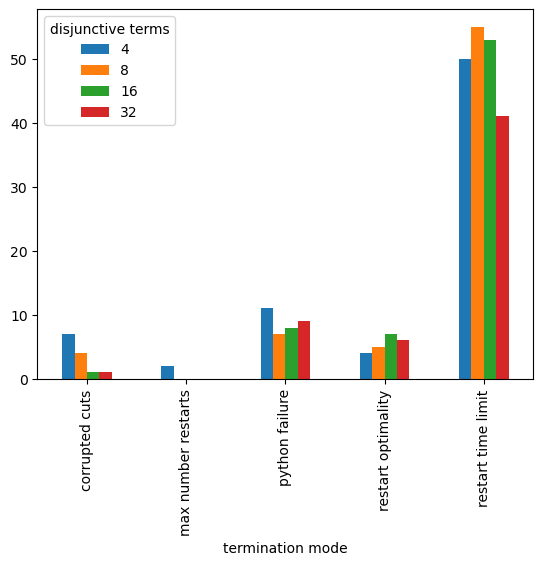

In [19]:
df = raw_termination_df.groupby(['disjunctive terms',
                                 'termination mode']).count()['instance'].reset_index()
df.pivot(index='termination mode', columns='disjunctive terms')['instance'].plot(kind='bar')
plt.show()

In [27]:
raw_termination_df.pivot(index='instance', columns='disjunctive terms')['termination mode']


disjunctive terms,4,8,16,32
instance,,,,
22433,NaN,restart optimality,restart optimality,restart optimality
23588,restart time limit,restart time limit,restart time limit,NaN
assign1-5-8,restart time limit,restart time limit,restart time limit,restart time limit
b-ball,NaN,restart time limit,restart time limit,restart time limit
beavma,restart optimality,NaN,NaN,NaN
...,...,...,...,...
supportcase14,corrupted cuts,restart time limit,restart time limit,restart optimality
supportcase16,python failure,corrupted cuts,restart optimality,restart optimality
supportcase20,python failure,restart time limit,NaN,NaN


### Number of Restarts

array([[<AxesSubplot: title={'center': '4'}>],
       [<AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '16'}>],
       [<AxesSubplot: title={'center': '32'}>]], dtype=object)

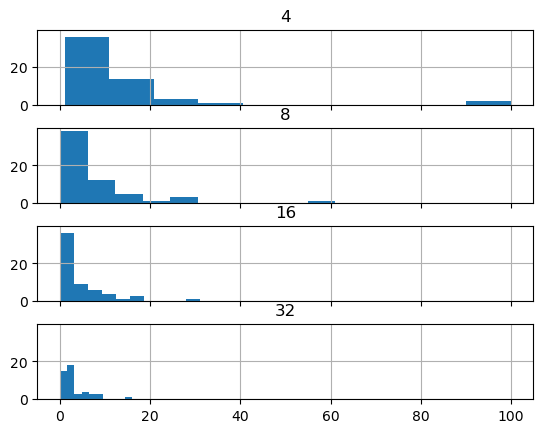

In [28]:
df = raw_restart_df.groupby(['instance', 'disjunctive terms']).max()['restart'].reset_index()
df = df.pivot(index='instance', columns='disjunctive terms')['restart']
df.hist(sharex=True, sharey=True, layout=(len(df.columns), 1))

## Clean Restart and Cut Iteration Data

In [29]:
# check to make sure no mistakes made in generating cuts via unreasonable root gaps
bad_runs = raw_cut_df.loc[raw_cut_df['root gap closed'] > 1.01, ['instance', 'cuts', 'disjunctive terms']].drop_duplicates()
bad_runs

,instance,cuts,disjunctive terms
404,mas76,disjunctive only,4
17903,mad,default and disjunctive,8


In [30]:
# remove unreasonable runs from raw_cut_df
merge = pd.merge(raw_cut_df, bad_runs, on=['instance', 'cuts', 'disjunctive terms'],
                 indicator=True, how='outer')
raw_cut_df = merge[merge['_merge'] == 'left_only'].drop('_merge', axis=1)

In [31]:
# remove unreasonable runs from raw_restart_df
merge = pd.merge(raw_restart_df, bad_runs[bad_runs['cuts'] == 'disjunctive only'],
                 on=['instance', 'disjunctive terms'], indicator=True, how='outer')
raw_restart_df = merge[merge['_merge'] == 'left_only'].drop('_merge', axis=1)

## Plot Gap Closed at Each Cut Generation Iteration

In [32]:
# group dual bound progress at root by cuts applied and disjunctive terms
cut_df = dict(tuple(raw_cut_df.groupby(['cuts', 'disjunctive terms'])))
cuts = list({k[0] for k in cut_df})
disjunctive_term_list = list({k[1] for k in cut_df})

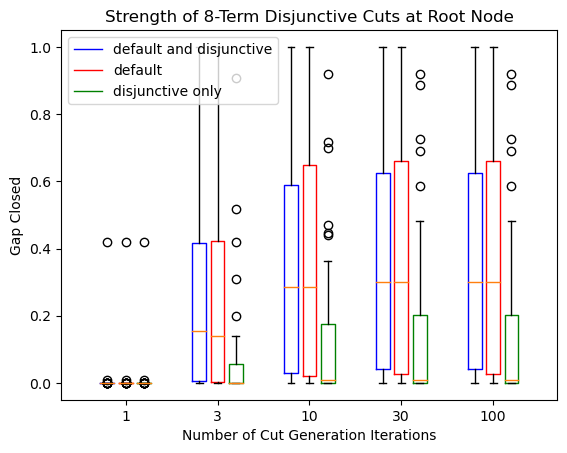

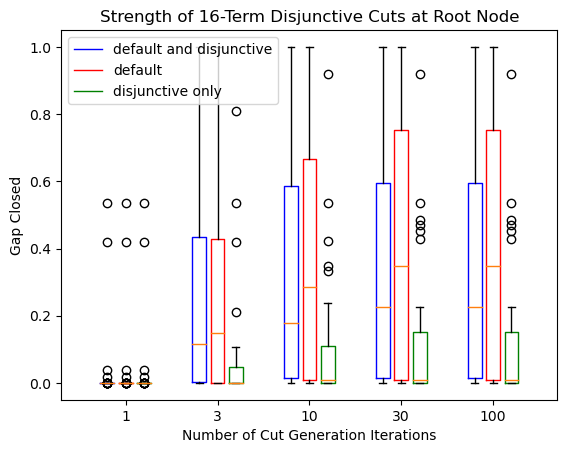

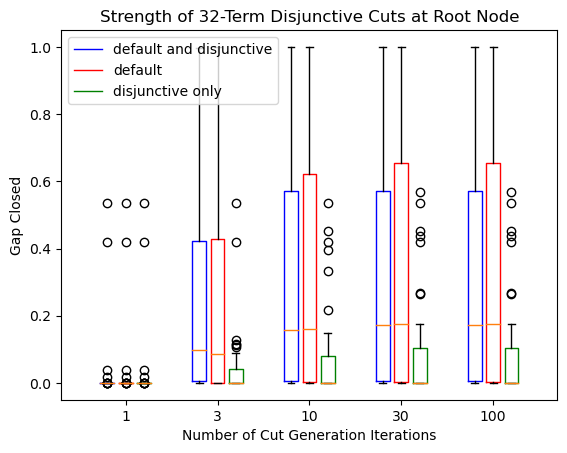

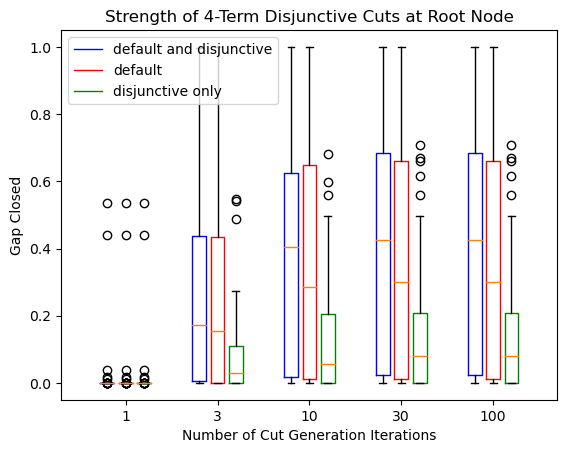

In [33]:
# which cut generation iterations to plot
iterations = [1, 3, 10, 30, 100]

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g']  # must have same length as cuts
bp = {}

# make one plot for each number of disjunctive terms used
for disjunctive_terms in disjunctive_term_list:
    fig, ax = plt.subplots()
    
    # make a collection of box plots for each set of cuts used, plotting selected iterations
    for i, cut in enumerate(cuts):
        
        # get the dual bound progress for this combo of disjunctive term and type of cuts
        df = cut_df[cut, disjunctive_terms]
        
        # filter down to iterations of interest
        df = df[df['cut generation iteration'].isin(iterations)]
        
        # make one box plot for each cut generation iteration of interest
        gb = dict(tuple(df.groupby(['cut generation iteration'])['root gap closed']))
        bp[cut] = ax.boxplot(gb.values(), positions=np.arange(len(iterations))+(i - 1)*shift,
                             boxprops=dict(color=colors[i]), widths=.15)

    # set plot attributes
    ax.legend([b["boxes"][0] for b in bp.values()], bp.keys(), loc='upper left')
    ax.set_xticks(np.arange(len(iterations)))
    ax.set_xticklabels(iterations)
    ax.set(
        title=f'Strength of {disjunctive_terms}-Term Disjunctive Cuts at Root Node',
        xlabel='Number of Cut Generation Iterations',
        ylabel='Gap Closed',
        ylim=(-.05,1.05)
    )

    plt.show()

## Plot Gap Closed By Disjunctive Cuts after Each Restart

In [42]:
raw_restart_df

,instance,disjunctive terms,restart,root gap closed,cuts
0,gen-ip036,8,0,0.000000e+00,NaN
1,gen-ip036,8,1,6.519614e-02,NaN
4,mas76,16,0,6.548131e-15,NaN
5,mas76,16,1,6.438894e-02,NaN
6,dcmulti,4,0,3.736174e-13,NaN
...,...,...,...,...,...
1817,sp150x300d,4,5,4.663080e-01,NaN
1818,sp150x300d,4,6,4.832743e-01,NaN
1819,sp150x300d,4,7,4.962682e-01,NaN
1820,sp150x300d,4,8,4.971657e-01,NaN


In [35]:
# filter out restarts that occur less than a certain number of times
min_restarts = 10
count = raw_restart_df['restart'].value_counts()
raw_restart_df = raw_restart_df[raw_restart_df['restart'].isin(count.index[count.gt(min_restarts)])]

In [36]:
# group dataframe by number of disjunctive terms
restart_df = dict(tuple(raw_restart_df.groupby('disjunctive terms')[['restart', 'root gap closed']]))

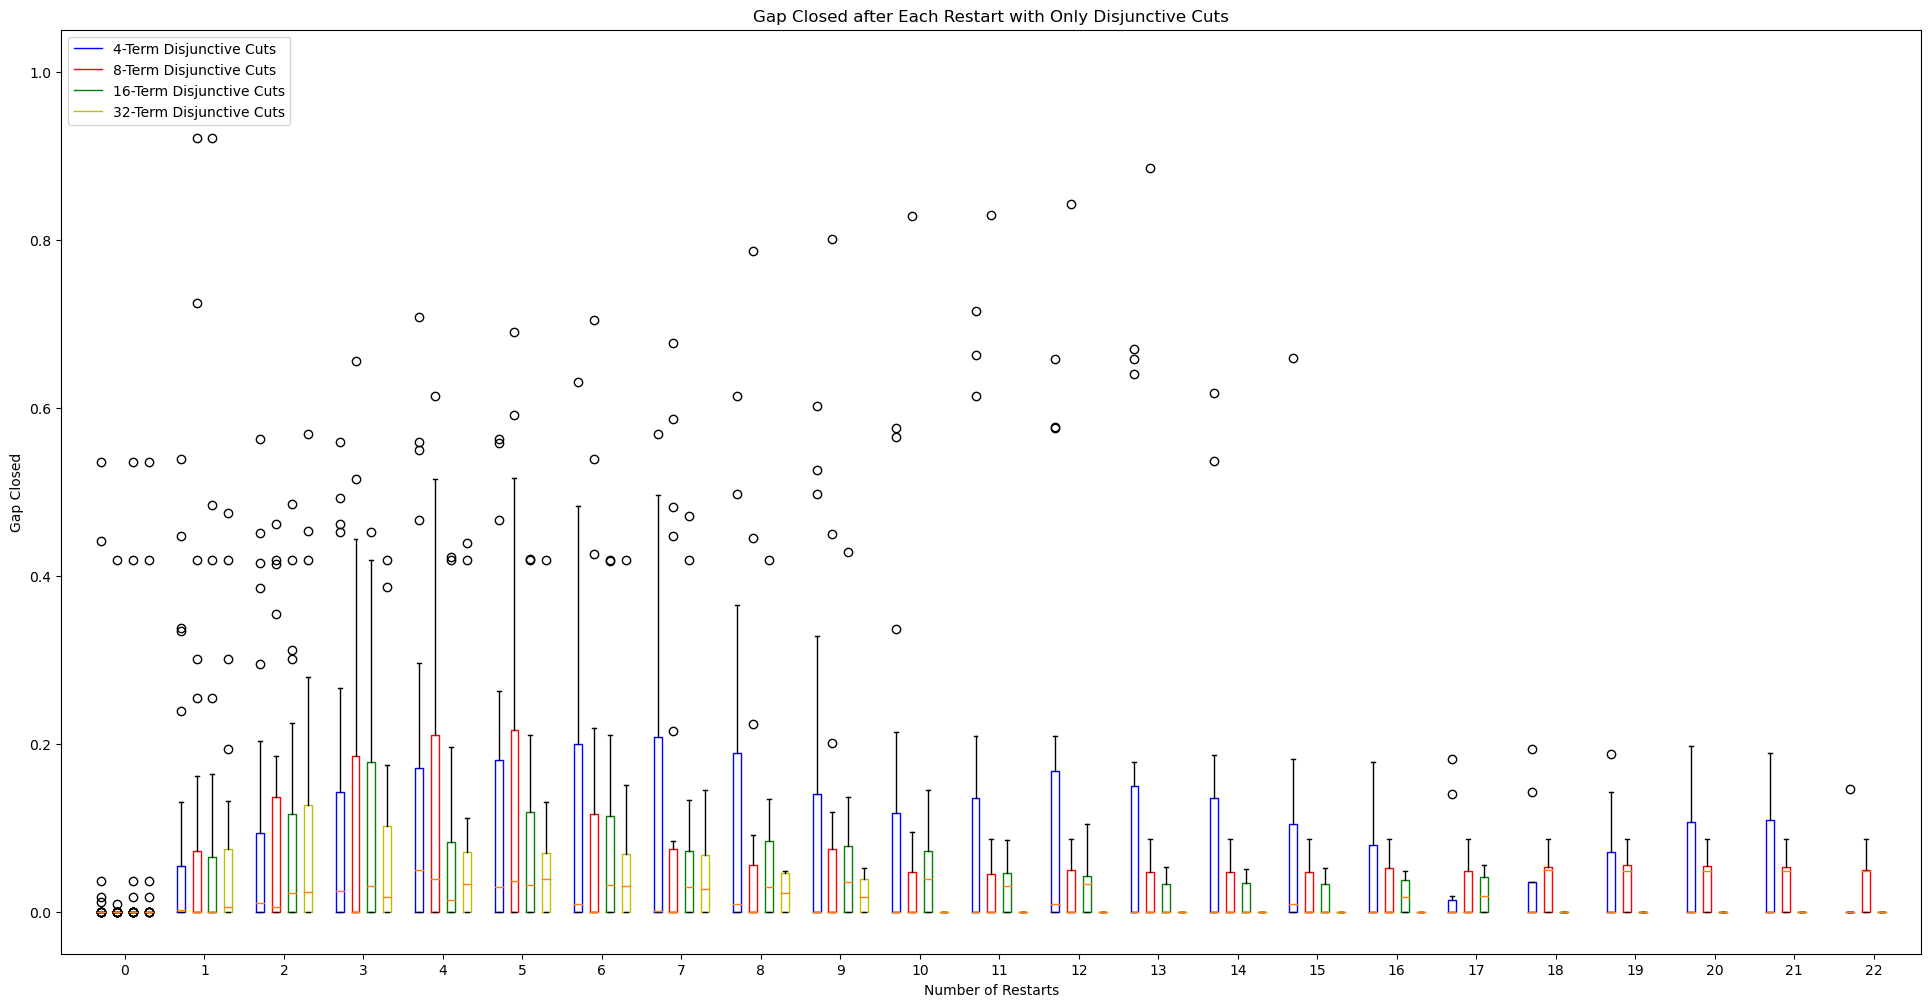

In [41]:
# make one plot for each number of disjunctive terms used
fig, ax = plt.subplots()

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g', 'y']
assert len(colors) == len(restart_df), "colors must have same length as disjunctive term list"
bp = {}
ticks = np.sort(raw_restart_df['restart'].unique())

# for each number of disjunctive terms plot progress of each subsequent restart as box plot
for i, (disjunctive_terms, df) in enumerate(restart_df.items()):
    
    # for each number of disjunctive terms group data frame by restart
    gb = dict(tuple(df.groupby(['restart'])['root gap closed']))
    
    # plot each restart as a boxplot
    bp[disjunctive_terms] = ax.boxplot(gb.values(), positions=np.arange(len(gb))+(i - 1.5)*shift,
                                       boxprops=dict(color=colors[i]), widths=.1)

# set plot attributes
ax.legend([b["boxes"][0] for b in bp.values()], [f'{x}-Term Disjunctive Cuts' for x in bp],
          loc='upper left')
ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks)
ax.set(
    title=f'Gap Closed after Each Restart with Only Disjunctive Cuts',
    xlabel='Number of Restarts',
    ylabel='Gap Closed',
    ylim=(-.05,1.05),
)
fig.set_size_inches(24, 12)

plt.show()